In [49]:
import numpy as np
import matplotlib.pyplot as plt


# Experimental section

In [50]:
def print_coloring_stats(J, binary_solutions):
    # Count number of times adjacent nodes share a color
    coloring_match = np.sum(J * (binary_solutions @ binary_solutions.T)) // 2  # Avoid double-counting
    
    # Count number of nodes assigned more than one color
    coloring_repeat = np.sum(np.sum(binary_solutions, axis=1) > 1)
    
    print("Number of times two adjacent nodes have the same color:", coloring_match)
    print("Number of times one node is assigned more than one color:", coloring_repeat)


In [51]:
def get_coupling(J, x):
    coloring_match = x*np.sum(J * (x @ x.T > 0)) // 2  # Count pairs where adjacent nodes share a color
    coloring_repeat = x*np.sum(np.sum(x > 0, axis=1) > 1)  # Count nodes with multiple colors
    return coloring_match + coloring_repeat

def get_coupling(J, x):
    coloring_match = np.sum(J * (x @ x.T > 0)) // 2  # Count pairs where adjacent nodes share a color
    coloring_repeat = np.sum(np.sum(x > 0, axis=1) > 1)  # Count nodes with multiple colors
    return x*(coloring_match + coloring_repeat)/(x.shape[0] + x.shape[1])

In [52]:

J = np.array([[0, 0, 1, 0, 1],
         [0, 0, 0, 1, 1],
         [1, 0, 0, 0, 1],
         [0, 1, 0, 0, 1],
         [1, 1, 1, 1, 0]])

num_colors = 3

steps=10000
a0=1.0
c0=1.0 
dt=0.01
gradient_list = []
x_max_list = []
y_max_list = []
x_min_list = []
y_min_list = []

# Get problem size
N = J.shape[0]

# Initialize positions and momenta
x = np.random.uniform(-0.5, 0.5, (N, num_colors))  # Position variables
y = np.zeros((N, num_colors))                 # Momentum variables

coupling = np.zeros((N, num_colors)) 

# Define a(t) function - linear increase from 0 to a0
def a_t_func(t):
    return min(a0 * t / (0.2 * steps * dt), a0)

    
# Main simulation loop
for step in range(1, steps + 1):
    t = step * dt
    a_t = a_t_func(t)
    
    # First part of symplectic Euler: update momenta
    # ẏ_i = -[a0 - a(t)]x_i + c0 ∑J_ij*x_j
    coupling = get_coupling(J,x)
    y -= dt * ((a0 - a_t) * x - c0 * coupling)
    
    # Second part: update positions
    # ẋ_i = a0 * y_i
    x += dt * a0 * y

    gradient_list.append(coupling.sum())
    
    # Apply inelastic walls: for any |x_i| > 1
    outside_range = np.abs(x) > 1.0
    if np.any(outside_range):
        # Replace with sign (±1)
        x[outside_range] = np.sign(x[outside_range])
        # Set corresponding momenta to 0
        y[outside_range] = 0.0
    


    x_max_list.append(x.max())
    y_max_list.append(y.max())
    x_min_list.append(x.min())
    y_min_list.append(y.min())

binary_solution = np.sign(x)



print_coloring_stats(J, binary_solution)
binary_solution

Number of times two adjacent nodes have the same color: 10.0
Number of times one node is assigned more than one color: 2


array([[ 1., -1.,  1.],
       [ 1.,  1.,  1.],
       [ 1., -1.,  1.],
       [ 1., -1.,  1.],
       [ 1.,  1.,  1.]])

In [53]:
# plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
# plt.plot(gradient_list, linestyle='-', color='b')
# plt.xlabel("Index")
# plt.ylabel("Value")
# plt.title("Line Chart of gradient_list")
# plt.grid(True)
# plt.show()

# print(binary_solution)

# plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
# plt.plot(x_max_list, linestyle='-', color='b')
# plt.xlabel("Index")
# plt.ylabel("Value")
# plt.title("Line Chart of x_max_list")
# plt.grid(True)
# plt.show()



# plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
# plt.plot(y_max_list, linestyle='-', color='b')
# plt.xlabel("Index")
# plt.ylabel("Value")
# plt.title("Line Chart of y_max_list")
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
# plt.plot(x_min_list, linestyle='-', color='b')
# plt.xlabel("Index")
# plt.ylabel("Value")
# plt.title("Line Chart of x_min_list")
# plt.grid(True)
# plt.show()



# plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
# plt.plot(y_min_list, linestyle='-', color='b')
# plt.xlabel("Index")
# plt.ylabel("Value")
# plt.title("Line Chart of y_min_list")
# plt.grid(True)
# plt.show()


# Greedy Coloring

Node colors: {0: 0, 1: 0, 2: 1, 3: 1, 4: 2}
Number of violations: 0


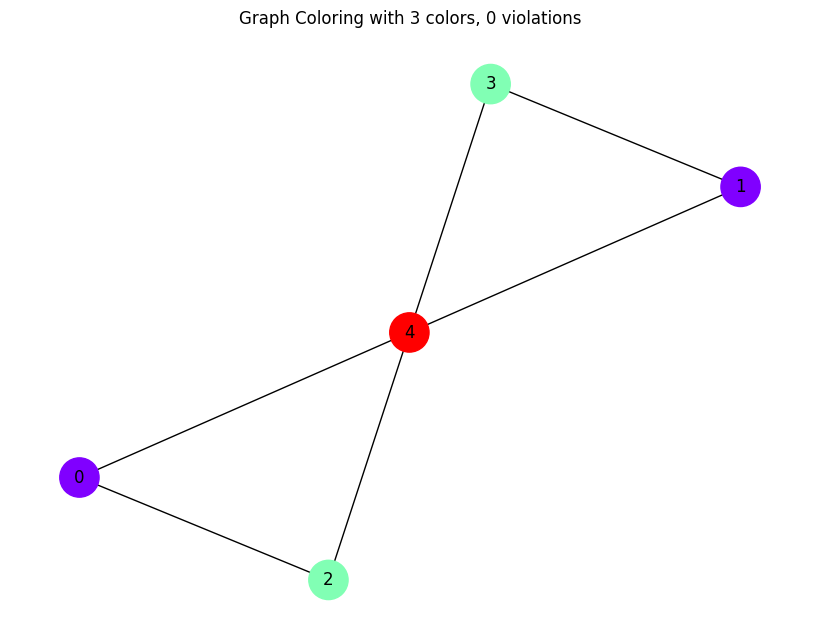

In [54]:
import numpy as np
import networkx as nx

def greedy_coloring(num_colors, adjacency_matrix):
    """
    Colors a graph using the greedy algorithm with a limited number of colors.
    
    Parameters:
    -----------
    num_colors : int
        Maximum number of colors to use (0 to num_colors-1)
    adjacency_matrix : numpy.ndarray
        Adjacency matrix representation of the graph
    
    Returns:
    --------
    tuple
        (node_colors, violations)
        - node_colors: Dictionary mapping node index to color
        - violations: Number of edges where both endpoints have the same color
    """
    # Convert adjacency matrix to NetworkX graph
    G = nx.from_numpy_array(adjacency_matrix)
    
    # Initialize colors dictionary
    node_colors = {}
    
    # Process nodes in order (can be customized with different node orderings)
    for node in G.nodes():
        # Get colors of neighbors
        neighbor_colors = set()
        for neighbor in G.neighbors(node):
            if neighbor in node_colors:
                neighbor_colors.add(node_colors[neighbor])
        
        # Find the smallest available color
        color = 0
        while color in neighbor_colors and color < num_colors:
            color += 1
            
        # If we've exceeded available colors, use the last available color
        if color >= num_colors:
            color = num_colors - 1
            
        # Assign the color
        node_colors[node] = color
    
    # Count violations (edges where both endpoints have the same color)
    violations = 0
    for u, v in G.edges():
        if node_colors[u] == node_colors[v]:
            violations += 1
    
    return node_colors, violations

colors, violations = greedy_coloring(num_colors, J)

print("Node colors:", colors)
print("Number of violations:", violations)

# Visualize the coloring (optional)
import matplotlib.pyplot as plt

G = nx.from_numpy_array(J)
color_map = [colors[node] for node in G.nodes()]

plt.figure(figsize=(8, 6))
nx.draw(G, node_color=color_map, with_labels=True, 
        cmap=plt.cm.rainbow, node_size=800)
plt.title(f"Graph Coloring with {len(set(color_map))} colors, {violations} violations")
plt.show()